In [1]:
import matplotlib.pyplot as plt  # 画图模块
import numpy as np # 数据处理最重要的模块
import pandas as pd # 数据处理最重要的模块
import scipy.stats as stats # 统计模块
import scipy
from datetime import datetime # 时间模块
from IPython.core.interactiveshell import InteractiveShell # jupyter运行输出的模块
import statsmodels.formula.api as smf  # OLS regression
import pyreadr # read RDS file
from matplotlib import style
import matplotlib.dates as mdates
from pandas._libs.tslibs.offsets import MonthEnd

# from matplotlib.font_manager import FontProperties # 作图中文
# from pylab import mpl
# mpl.rcParams['font.sans-serif'] = ['SimHei']
# plt.rcParams['font.family'] = 'Times New Roman'

#输出矢量图 渲染矢量图
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

#显示每一个运行结果
# InteractiveShell.ast_node_interactivity = 'all'

#设置行不限制数量
#pd.set_option('display.max_rows',None)

#设置列不限制数量
pd.set_option('display.max_columns', None)

# plt.rcParams['font.sans-serif'] = ['SimHei'] # 或者其他支持中文的字体
# plt.rcParams['axes.unicode_minus'] = False # 正确显示负号

# 估计个股Beta

\begin{align*}
		E\left[R_{i, t}\right]=R_{f, t}+\beta_{i}\left(E\left[R_{m, t}\right]-R_{f, t}\right)
\end{align*}
where

\begin{align*}
	\beta_{i}=\frac{\operatorname{Cov}\left(R_{i, t}, R_{m, t}\right)}{\operatorname{Var}\left(R_{m, t}\right)}
\end{align*}

在实证研究中，常常使用历史数据来估计股票的$\beta$。
具体而言，在$t$月，可以使用
- $t-k$月到$t$月的日收益回归到日收益率上，$k = 6, 12, 24$
- $t-k$月到$t$月的月收益回归到月收益率上，$k = 12, 24, 60, 120$

## 月度数据估计

### 导入个股月交易数据

- Stkcd [证券代码] - 以上交所、深交所公布的证券代码为准
- Trdmnt [交易月份] - 以YYYY-MM表示
- Opndt [月开盘日期] - 月第一个交易日。以DD表示，为OPNPRC的所在日，“DD”＝本月无交易
- Mopnprc [月开盘价] - 月第一个交易日的开盘价。
- Clsdt [月收盘日期] - 月最后一个交易日。以DD表示，为CLSPRC的所在日，“DD”＝本月无交易
- Mclsprc [月收盘价] - 月最后一个交易日的收盘价。
- Mnshrtrd [月个股交易股数] - 月内该股票的交易数量。计算公式为：月开盘日期与交易日期期间内日成交量之和。
- Mnvaltrd [月个股交易金额] - 月内该股票的交易金额。计算公式为：月开盘日期与交易日期期间内日成交额之和。A股以人民币元计，上海B以美元计，深圳B以港币计。
- Msmvosd [月个股流通市值] - 个股的流通股数与月收盘价的乘积。计算公式为：个股的流通股数与月收盘价的乘积。 A股以人民币元计，上海B以美元计，深圳B以港币计，注意单位是千
- Msmvttl [月个股总市值] - 个股的发行总股数与月收盘价的乘积。计算公式为：个股的发行总股数与月收盘价的乘积，A股以人民币元计，上海B股以美元计，深圳B股以港币计，注意单位是千
- Ndaytrd [月交易天数] - 计算公式为：月内实际交易的天数之和。
- Mretwd [考虑现金红利再投资的月个股回报率] - 字段说明见说明书“周、月、年个股回报率的计算方法”。
- Mretnd [不考虑现金红利再投资的月个股回报率] - 字段说明见说明书“周、月、年个股回报率的计算方法”。
- Markettype [市场类型] - 1=上证A股市场 (不包含科创板），2=上证B股市场，4=深证A股市场（不包含创业板），8=深证B股市场，16=创业板， 32=科创板，64=北证A股市场。
- Capchgdt [最新股本变动日期] - 上市公司最近一次股本发生变化的日期
- Ahshrtrd_M [月盘后成交总量] - 月科创板股票盘后总成交量。计算公式为：月开盘日期与交易日期期间内日盘后成交量之和。
- Ahvaltrd_M [月盘后成交总额] - 月科创板股票盘后总成交额。计算公式为：月开盘日期与交易日期期间内日盘后成交额之和。

In [34]:
Ret_mon = pd.read_csv('/Volumes/BetaAlpha/Assetpricing/Input/Individual Return/TRD_Mnth199012-202412.csv')
# 补齐股票代码到6位，左边补0
Ret_mon['Stkcd'] = Ret_mon['Stkcd'].astype(str).str.zfill(6)

# 将Trdmnt转换为月末日期格式
Ret_mon['Trdmnt'] = pd.to_datetime(Ret_mon['Trdmnt'] + '-01') + MonthEnd(0)

# 将Capchgdt转换为日期格式
Ret_mon['Capchgdt'] = pd.to_datetime(Ret_mon['Capchgdt'])

# 将数值型列转换为数值类型
numeric_columns = ['Mopnprc', 'Mclsprc', 'Mnshrtrd', 'Mnvaltrd', 'Msmvosd', 
                  'Msmvttl', 'Ndaytrd', 'Mretwd', 'Mretnd', 'Markettype', 
                  'Ahshrtrd_M', 'Ahvaltrd_M']

for col in numeric_columns:
    Ret_mon[col] = pd.to_numeric(Ret_mon[col], errors='coerce')

# 修改列名
Ret_mon = Ret_mon.rename(columns={'Trdmnt': 'month', 
                                  'Mopnprc': 'Openprice',
                                  'Mclsprc': 'Closeprice',
                                  'Mnshrtrd': 'TradingVolume',
                                  'Mnvaltrd': 'TradingValue',
                                  'Msmvosd': 'FloatMarketValue',
                                  'Msmvttl': 'TotalMarketValue',
                                  'Ndaytrd': 'TradingDays',
                                  'Mretwd': 'Return_1',
                                  'Mretnd': 'Return_2',
                                  'Markettype': 'MarketType'
                                  })

# 保留之前重命名过的列
Ret_mon = Ret_mon[['Stkcd', 'month', 'Openprice', 'Closeprice', 'TradingVolume', 'TradingValue', 'FloatMarketValue', 'TotalMarketValue', 'TradingDays', 'Return_1', 'Return_2', 'MarketType']]

Ret_mon['FloatMarketValue'] = Ret_mon['FloatMarketValue'] * 1000
Ret_mon['TotalMarketValue'] = Ret_mon['TotalMarketValue'] * 1000

Ret_mon


,Stkcd,month,Openprice,Closeprice,TradingVolume,TradingValue,FloatMarketValue,TotalMarketValue,TradingDays,Return_1,Return_2,MarketType
0,000001,1991-04-30,49.00,43.68,13400,6.150000e+05,1157520.00,2118487.47,20,NaN,NaN,4
1,000001,1991-05-31,43.46,38.34,187800,7.675000e+06,1016010.00,1859496.56,24,-0.122253,0.235714,4
2,000001,1991-06-30,38.53,33.99,30600,1.094000e+06,900735.00,1648520.81,23,-0.113459,-0.113459,4
3,000001,1991-07-31,33.65,29.54,6100,1.940430e+05,782810.00,1432695.05,16,-0.130921,-0.130921,4
4,000001,1991-08-31,29.39,15.00,3243100,4.957624e+07,674833.82,1346274.65,15,-0.411588,-0.411587,4
...,...,...,...,...,...,...,...,...,...,...,...,...
837466,920118,2024-10-31,27.74,27.29,46231502,1.186306e+09,376465.55,1388951.84,18,0.237642,0.237642,64
837467,920118,2024-11-30,27.01,32.34,43779839,1.284801e+09,446130.30,1645976.64,21,0.185049,0.185049,64
837468,920118,2024-12-31,32.81,24.40,22849206,6.947498e+08,336598.00,1241862.40,22,-0.245516,-0.245516,64
837469,920128,2024-11-30,52.00,46.14,15612317,8.584411e+08,788994.00,3621528.60,1,NaN,NaN,64


### 数据过滤

In [35]:
# 保留正常 A 股 Markettype = 1,4,16
Ret_mon = Ret_mon[(Ret_mon['MarketType'] == 1) | (Ret_mon['MarketType'] == 4) | (Ret_mon['MarketType'] == 16)]

# 添加列 Rank 表示上市第几个月
# 首先按股票代码分组，然后计算每只股票的上市月份
Ret_mon = Ret_mon.sort_values(['Stkcd', 'month'])
Ret_mon['first_month'] = Ret_mon.groupby('Stkcd')['month'].transform('min')
# 计算上市月份差值，使用 pd.DatetimeIndex 获取年份和月份，然后计算月份差
Ret_mon['Rank'] = (pd.DatetimeIndex(Ret_mon['month']).year - pd.DatetimeIndex(Ret_mon['first_month']).year) * 12 + \
                  (pd.DatetimeIndex(Ret_mon['month']).month - pd.DatetimeIndex(Ret_mon['first_month']).month) + 1

Ret_mon

,Stkcd,month,Openprice,Closeprice,TradingVolume,TradingValue,FloatMarketValue,TotalMarketValue,TradingDays,Return_1,Return_2,MarketType,first_month,Rank
0,000001,1991-04-30,49.00,43.68,13400,6.150000e+05,1157520.00,2118487.47,20,NaN,NaN,4,1991-04-30,1
1,000001,1991-05-31,43.46,38.34,187800,7.675000e+06,1016010.00,1859496.56,24,-0.122253,0.235714,4,1991-04-30,2
2,000001,1991-06-30,38.53,33.99,30600,1.094000e+06,900735.00,1648520.81,23,-0.113459,-0.113459,4,1991-04-30,3
3,000001,1991-07-31,33.65,29.54,6100,1.940430e+05,782810.00,1432695.05,16,-0.130921,-0.130921,4,1991-04-30,4
4,000001,1991-08-31,29.39,15.00,3243100,4.957624e+07,674833.82,1346274.65,15,-0.411588,-0.411587,4,1991-04-30,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
787635,605599,2024-08-31,11.51,10.74,60492042,6.675452e+08,6300919.57,8353333.57,22,-0.065274,-0.065274,1,2021-09-30,36
787636,605599,2024-09-30,10.56,11.89,68255221,7.093424e+08,9247778.04,9247778.04,19,0.107076,0.107076,1,2021-09-30,37
787637,605599,2024-10-31,12.91,10.65,100720810,1.106652e+09,8283333.57,8283333.57,18,-0.104289,-0.104289,1,2021-09-30,38
787638,605599,2024-11-30,10.63,11.50,108258572,1.199394e+09,8944444.70,8944444.70,21,0.079812,0.079812,1,2021-09-30,39


### 导入市场收益率

In [36]:
# Load Market Returns
# Cmmvosd [综合月市场总流通市值] - 月内所有个股的流通市值 汇总数。计算公式为：流通股数*月收盘价。 计量货币：人民币元，注意单位是千
Marketret_mon_stock = pd.read_csv('Data/TRD_Cnmont2024.csv')
Marketret_mon_stock = Marketret_mon_stock[Marketret_mon_stock['Markettype'] == 21]
Marketret_mon_stock = Marketret_mon_stock[['Trdmnt', 'Cmretwdos', 'Cmretwdeq','Cmmvosd']].dropna()
# month 列 + 月末
# 仅将日期转换为月份，舍弃日期和时间信息
Marketret_mon_stock['month'] = pd.to_datetime(Marketret_mon_stock['Trdmnt'], format='%Y-%m')+MonthEnd(0)
Marketret_mon_stock['MarketR'] = Marketret_mon_stock['Cmretwdos'].astype(float)
Marketret_mon_stock['MarketR_e'] = Marketret_mon_stock['Cmretwdeq'].astype(float)
Marketret_mon_stock['Marketvalue'] = Marketret_mon_stock['Cmmvosd'].astype(float)
Marketret_mon_stock = Marketret_mon_stock[['month', 'MarketR', 'MarketR_e','Marketvalue']]
Marketret_mon_stock

,month,MarketR,MarketR_e,Marketvalue
19,1991-01-31,0.029998,0.036554,1.931395e+06
37,1991-02-28,0.010203,0.021860,1.819734e+06
55,1991-03-31,-0.099663,-0.060425,1.468212e+06
73,1991-04-30,-0.079652,-0.031449,2.508786e+06
91,1991-05-31,-0.074521,0.005375,2.321827e+06
...,...,...,...,...
7665,2024-08-31,-0.031468,-0.033685,6.000512e+10
7684,2024-09-30,0.195992,0.227078,7.182264e+10
7703,2024-10-31,-0.003409,0.070220,7.162078e+10
7722,2024-11-30,0.009724,0.045312,7.240424e+10


### 无风险利率

In [6]:
# Load Risk Free Rate
riskfree = pd.read_csv('Data/TRD_Nrrate2024.csv')
riskfree_mon = riskfree[['Clsdt', 'Nrrmtdt']].dropna()
riskfree_mon = riskfree_mon.drop([0,1])
riskfree_mon['month'] = pd.to_datetime(riskfree_mon['Clsdt'])+MonthEnd(0)
riskfree_mon['rfmonth'] = riskfree_mon['Nrrmtdt'].astype(float) / 100
riskfree_mon = riskfree_mon.groupby('month').agg({'rfmonth':'mean'}).reset_index()
riskfree_mon

,month,rfmonth
0,1990-12-31,0.006930
1,1991-01-31,0.006930
2,1991-02-28,0.006930
3,1991-03-31,0.006930
4,1991-04-30,0.006651
...,...,...
404,2024-08-31,0.001118
405,2024-09-30,0.001118
406,2024-10-31,0.001118
407,2024-11-30,0.001118


### 合并数据

In [38]:
Ret_mon = pd.merge(Ret_mon,Marketret_mon_stock[['month','MarketR']], on='month',how='left')
Ret_mon = pd.merge(Ret_mon,riskfree_mon,on='month',how='left')
Ret_mon

,Stkcd,month,Openprice,Closeprice,TradingVolume,TradingValue,FloatMarketValue,TotalMarketValue,TradingDays,Return_1,Return_2,MarketType,first_month,Rank,MarketR,rfmonth
0,000001,1991-04-30,49.00,43.68,13400,6.150000e+05,1157520.00,2118487.47,20,NaN,NaN,4,1991-04-30,1,-0.079652,0.006651
1,000001,1991-05-31,43.46,38.34,187800,7.675000e+06,1016010.00,1859496.56,24,-0.122253,0.235714,4,1991-04-30,2,-0.074521,0.006092
2,000001,1991-06-30,38.53,33.99,30600,1.094000e+06,900735.00,1648520.81,23,-0.113459,-0.113459,4,1991-04-30,3,-0.079348,0.006092
3,000001,1991-07-31,33.65,29.54,6100,1.940430e+05,782810.00,1432695.05,16,-0.130921,-0.130921,4,1991-04-30,4,-0.082097,0.006092
4,000001,1991-08-31,29.39,15.00,3243100,4.957624e+07,674833.82,1346274.65,15,-0.411588,-0.411587,4,1991-04-30,5,-0.084185,0.006092
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
769034,605599,2024-08-31,11.51,10.74,60492042,6.675452e+08,6300919.57,8353333.57,22,-0.065274,-0.065274,1,2021-09-30,36,-0.031468,0.001118
769035,605599,2024-09-30,10.56,11.89,68255221,7.093424e+08,9247778.04,9247778.04,19,0.107076,0.107076,1,2021-09-30,37,0.195992,0.001118
769036,605599,2024-10-31,12.91,10.65,100720810,1.106652e+09,8283333.57,8283333.57,18,-0.104289,-0.104289,1,2021-09-30,38,-0.003409,0.001118
769037,605599,2024-11-30,10.63,11.50,108258572,1.199394e+09,8944444.70,8944444.70,21,0.079812,0.079812,1,2021-09-30,39,0.009724,0.001118


In [39]:
Ret_mon['ret'] = Ret_mon['Return_1'] - Ret_mon['rfmonth']
Ret_mon['ret_mkt'] = Ret_mon['MarketR'] - Ret_mon['rfmonth']

# 通过合并获取下一个月的收益率
next_month_ret = Ret_mon[['Stkcd', 'month', 'ret']].copy()
next_month_ret['month'] = next_month_ret['month'] - MonthEnd(1)
next_month_ret = next_month_ret.rename(columns={'ret': 'next_ret'})

# 合并数据
Ret_mon = pd.merge(Ret_mon, next_month_ret[['Stkcd', 'month', 'next_ret']], 
                  on=['Stkcd', 'month'], 
                  how='left')

Ret_mon

,Stkcd,month,Openprice,Closeprice,TradingVolume,TradingValue,FloatMarketValue,TotalMarketValue,TradingDays,Return_1,Return_2,MarketType,first_month,Rank,MarketR,rfmonth,ret,ret_mkt,next_ret
0,000001,1991-04-30,49.00,43.68,13400,6.150000e+05,1157520.00,2118487.47,20,NaN,NaN,4,1991-04-30,1,-0.079652,0.006651,NaN,-0.086303,-0.128345
1,000001,1991-05-31,43.46,38.34,187800,7.675000e+06,1016010.00,1859496.56,24,-0.122253,0.235714,4,1991-04-30,2,-0.074521,0.006092,-0.128345,-0.080613,-0.119551
2,000001,1991-06-30,38.53,33.99,30600,1.094000e+06,900735.00,1648520.81,23,-0.113459,-0.113459,4,1991-04-30,3,-0.079348,0.006092,-0.119551,-0.085440,-0.137013
3,000001,1991-07-31,33.65,29.54,6100,1.940430e+05,782810.00,1432695.05,16,-0.130921,-0.130921,4,1991-04-30,4,-0.082097,0.006092,-0.137013,-0.088189,-0.417680
4,000001,1991-08-31,29.39,15.00,3243100,4.957624e+07,674833.82,1346274.65,15,-0.411588,-0.411587,4,1991-04-30,5,-0.084185,0.006092,-0.417680,-0.090277,-0.039425
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
769034,605599,2024-08-31,11.51,10.74,60492042,6.675452e+08,6300919.57,8353333.57,22,-0.065274,-0.065274,1,2021-09-30,36,-0.031468,0.001118,-0.066392,-0.032586,0.105958
769035,605599,2024-09-30,10.56,11.89,68255221,7.093424e+08,9247778.04,9247778.04,19,0.107076,0.107076,1,2021-09-30,37,0.195992,0.001118,0.105958,0.194874,-0.105407
769036,605599,2024-10-31,12.91,10.65,100720810,1.106652e+09,8283333.57,8283333.57,18,-0.104289,-0.104289,1,2021-09-30,38,-0.003409,0.001118,-0.105407,-0.004527,0.078694
769037,605599,2024-11-30,10.63,11.50,108258572,1.199394e+09,8944444.70,8944444.70,21,0.079812,0.079812,1,2021-09-30,39,0.009724,0.001118,0.078694,0.008606,-0.014161


### 估计beta

In [43]:
import statsmodels.api as sm
from tqdm import tqdm  # 进度条显示

# 定义时间窗口（单位：月）
windows = [12, 24, 60, 120]

# 初始化结果存储
results = []

# 按股票代码分组
stock_groups = dict(list(Ret_mon.groupby('Stkcd')))

# 对每只股票进行处理
for stkcd, stock_data in tqdm(stock_groups.items(), desc="处理股票"):
    # 按月份排序
    stock_data = stock_data.sort_values('month').reset_index(drop=True)
    
    # 创建一个临时字典，用于保存每个月份的结果
    monthly_results = {}
    
    # 对每个月进行处理
    for current_month in stock_data['month'].unique():
        # 初始化当月结果
        result = {
            'Stkcd': stkcd,
            'month': current_month
        }
        
        # 对每个窗口进行计算
        for window in windows:
            # 计算窗口的起始月份
            start_month = current_month - pd.DateOffset(months=window)
            
            # 提取窗口内的数据
            window_data = stock_data[(stock_data['month'] > start_month) & 
                                   (stock_data['month'] <= current_month)]
            
            # 确保窗口内有足够的数据点（至少 10 个点才能得到可靠的回归）
            if len(window_data) >= 10:
                # 检查数据是否有 NaN
                valid_data = window_data.dropna(subset=['ret', 'ret_mkt'])
                
                if len(valid_data) < 10:
                    # 如果有效数据不足，设置为 NaN
                    result[f'beta_{window}'] = np.nan
                    result[f'r2_{window}'] = np.nan
                    result[f'obs_{window}'] = len(valid_data)
                    continue
                
                # 提取超额收益率
                X = valid_data['ret_mkt'].values  # 市场超额收益率
                y = valid_data['ret'].values      # 个股超额收益率
                
                # 添加截距项
                X = sm.add_constant(X)
                
                try:
                    # 回归分析
                    model = sm.OLS(y, X).fit()
                    
                    # 提取 Beta 和 R²
                    beta = model.params[1] if len(model.params) > 1 else np.nan
                    r_squared = model.rsquared
                    
                    # 保存结果到特定列名
                    result[f'beta_{window}'] = beta
                    result[f'r2_{window}'] = r_squared
                    result[f'obs_{window}'] = len(valid_data)
                    
                except:
                    # 处理回归失败的情况
                    result[f'beta_{window}'] = np.nan
                    result[f'r2_{window}'] = np.nan
                    result[f'obs_{window}'] = 0
            else:
                # 数据不足，设置为 NaN
                result[f'beta_{window}'] = np.nan
                result[f'r2_{window}'] = np.nan
                result[f'obs_{window}'] = 0
        
        # 将当月结果添加到总结果列表
        results.append(result)

# 转换为 DataFrame
results_df = pd.DataFrame(results)

# 显示结果
results_df

处理股票: 100%|██████████| 4827/4827 [18:36<00:00,  4.32it/s] 


,Stkcd,month,beta_12,r2_12,obs_12,beta_24,r2_24,obs_24,beta_60,r2_60,obs_60,beta_120,r2_120,obs_120
0,000001,1991-04-30,NaN,NaN,0,NaN,NaN,0,NaN,NaN,0,NaN,NaN,0
1,000001,1991-05-31,NaN,NaN,0,NaN,NaN,0,NaN,NaN,0,NaN,NaN,0
2,000001,1991-06-30,NaN,NaN,0,NaN,NaN,0,NaN,NaN,0,NaN,NaN,0
3,000001,1991-07-31,NaN,NaN,0,NaN,NaN,0,NaN,NaN,0,NaN,NaN,0
4,000001,1991-08-31,NaN,NaN,0,NaN,NaN,0,NaN,NaN,0,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
769034,605599,2024-08-31,1.280755,0.300166,12,1.002494,0.215165,24,1.107498,0.316886,35,1.107498,0.316886,35
769035,605599,2024-09-30,0.828673,0.361919,12,0.710120,0.194635,24,0.902069,0.311463,36,0.902069,0.311463,36
769036,605599,2024-10-31,0.843992,0.344012,12,0.720664,0.182832,24,0.905547,0.301889,37,0.905547,0.301889,37
769037,605599,2024-11-30,0.839807,0.319322,12,0.753647,0.179030,24,0.911158,0.300167,38,0.911158,0.300167,38


### Save Data

In [55]:
# 保存结果到CSV文件
results_df.to_csv('/Volumes/BetaAlpha/Assetpricing/Output/Beta_estimation_monthly.csv', index=False)

# 打印保存成功信息
print("月度Beta估计结果已保存至: /Volumes/BetaAlpha/Assetpricing/Output/Beta_estimation_monthly.csv")

月度Beta估计结果已保存至: /Volumes/BetaAlpha/Assetpricing/Output/Beta_estimation_monthly.csv


## 日交易数据估计

### 导入日个股交易数据

- Stkcd [证券代码] - 以上交所、深交所公布的证券代码为准
- Trddt [交易日期] - 以YYYY-MM-DD表示
- Opnprc [日开盘价] - A股以人民币元计，上海B以美元计，深圳B以港币计
- Hiprc [日最高价] - A股以人民币元计，上海B以美元计，深圳B以港币计
- Loprc [日最低价] - A股以人民币元计，上海B以美元计，深圳B以港币计
- Clsprc [日收盘价] - A股以人民币元计，上海B以美元计，深圳B以港币计
- Dnshrtrd [日个股交易股数] - 0=没有交易量
- Dnvaltrd [日个股交易金额] - A股以人民币元计，上海B以美元计，深圳B以港币计，0=没有交易量
- Dsmvosd [日个股流通市值] - 计算公式为：个股的流通股数与收盘价的乘积，A股以人民币元计，上海B股以美元计，深圳B股以港币计，注意单位是千。（注：ABH同股，只计算A股总市值）
- Dsmvtll [日个股总市值] - 计算公式为：个股的总股数与收盘价的乘积，A股以人民币元计，上海B股以美元计，深圳B股以港币计，注意单位是千。（注：ABH同股，只计算A股总市值） A股：该字段计算用到的总股数计算公式为：个股的总股数= Nshrttl（总股数）-Nshrb (B股流通股数)-Nshrh(H股流通股数)-Nshroft(其它境外流通股)； B股：总股数Nshrttl=Nshrb B股流通股数；
- Dretwd [考虑现金红利再投资的日个股回报率] - 上市首日的前收盘价取招股价,字段说明见说明书"日个股回报率的计算"。
- Dretnd [不考虑现金红利的日个股回报率] - 上市首日的前收盘价取招股价,字段说明见说明书"日个股回报率的计算"。
- Adjprcwd [考虑现金红利再投资的收盘价的可比价格] - A股以人民币元计，上海B以美元计，深圳B以港币计，去除由于时间间隔和股本变动原因引起变化的以上市首日为基准的经过调整后的收盘价。字段说明见说明书"日收盘价的可比价格的计算"。
- Adjprcnd [不考虑现金红利的收盘价的可比价格] - A股以人民币元计，上海B以美元计，深圳B以港币计，去除由于时间间隔和股本变动原因引起变化的以上市首日为基准的经过调整后的收盘价。字段说明见说明书"日收盘价的可比价格的计算"。
- Markettype [市场类型] - 1=上证A股市场 (不包含科创板），2=上证B股市场，4=深证A股市场（不包含创业板），8=深证B股市场，16=创业板， 32=科创板，64=北证A股市场。
- Capchgdt [最新股本变动日期] - 上市公司股本最近一次发生变化的日期
- Trdsta [交易状态] - 1=正常交易，2=ST，3＝$*$ST，4＝S（2006年10月9日及之后股改未完成），5＝SST，6＝S$*$ST，7=G（2006年10月9日之前已完成股改），8=GST，9=G$*$ST，10=U（2006年10月9日之前股改未完成），11=UST，12=U$*$ST，13=N，14=NST，15=N$*$ST，16=PT
- 股票代码前带有“N”表示该股票是新上市的股票，且当天是其上市首日。这类股票在上市首日通常会有较高的关注度，价格波动也可能较大。等到第二个交易日，代码前的“N”标记就会消失。
- “PT”制度在2000年左右较为常见，但后来随着退市制度的改革，逐步被“ST”（特别警示）和“*ST”（退市风险警示）等标识所取代。
- Ahshrtrd_D [日盘后成交总量] - 创业板、科创板股票盘后成交量。
- Ahvaltrd_D [日盘后成交总额] - 创业板、科创板股票盘后成交额。
- PreClosePrice [昨收盘(交易所)] - 交易所接收的昨收盘价格，即经过除权的昨收价格。
- ChangeRatio [涨跌幅] - 基于昨收盘(交易所)计算的涨跌幅，计算公式为：日收盘价/昨收盘(交易所)-1
- LimitDown [跌停价] - 
- LimitUp [涨停价] - 
- LimitStatus [涨跌停状态] - 表示股票涨跌停的状态，1是涨停，-1是跌停，0是未涨跌停

In [2]:
import os
import pandas as pd
from tqdm import tqdm

# 获取文件夹中所有的csv文件
csv_files = [f for f in os.listdir('/Volumes/BetaAlpha/Assetpricing/Input/Individual Return/Daily CSV') if f.endswith('.csv')]

# 创建进度条
pbar = tqdm(csv_files, desc="读取CSV文件", unit="文件")

# 读取所有csv文件并合并，显示详细进度
data_frames = []
for f in pbar:
    pbar.set_postfix(file=f)  # 显示当前正在读取的文件名
    df = pd.read_csv(os.path.join('/Volumes/BetaAlpha/Assetpricing/Input/Individual Return/Daily CSV', f))
    data_frames.append(df)
    
Ret_day = pd.concat(data_frames, ignore_index=True)
Ret_day.sort_values(by=['Stkcd', 'Trddt'])
Ret_day

读取CSV文件: 100%|██████████| 19/19 [00:12<00:00,  1.57文件/s, file=TRD_Dalyr2020_2024_1.csv]


,Stkcd,Trddt,Opnprc,Hiprc,Loprc,Clsprc,Dnshrtrd,Dnvaltrd,Dsmvosd,Dsmvtll,Dretwd,Dretnd,Adjprcwd,Adjprcnd,Markettype,Capchgdt,Trdsta,Ahshrtrd_D,Ahvaltrd_D,PreClosePrice,ChangeRatio,LimitDown,LimitUp,LimitStatus
0,1,2000-01-04,17.50,18.55,17.20,18.29,8216086,1.473254e+08,19586806.29,28383283.31,0.048138,0.048138,374.364613,334.746046,4,1997-08-25,1,NaN,NaN,17.45,0.048138,15.71,19.20,0.0
1,1,2000-01-05,18.35,18.85,18.00,18.06,9399315,1.734752e+08,19340498.72,28026358.48,-0.012575,-0.012575,369.656912,330.536555,4,1997-08-25,1,NaN,NaN,18.29,-0.012575,16.46,20.12,0.0
2,1,2000-01-06,18.02,19.05,17.75,18.78,12022209,2.211925e+08,20111548.50,29143688.39,0.039867,0.039867,384.394064,343.714092,4,1997-08-25,1,NaN,NaN,18.06,0.039867,16.25,19.87,0.0
3,1,2000-01-07,19.00,19.77,18.90,19.54,22934633,4.435924e+08,20925434.38,30323092.18,0.040469,0.040469,399.949948,357.623714,4,1997-08-25,1,NaN,NaN,18.78,0.040469,16.90,20.66,0.0
4,1,2000-01-10,19.79,20.48,19.77,20.14,18521078,3.722945e+08,21567975.87,31254200.43,0.030706,0.030706,412.230908,368.604995,4,1997-08-25,1,NaN,NaN,19.54,0.030706,17.59,21.49,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16600831,2348,2022-01-25,2.24,2.27,2.17,2.21,33641400,7.456755e+07,1887866.62,2093312.00,-0.013393,-0.013393,15.192978,14.143940,4,2020-12-31,1,0.0,0.0,2.24,-0.013393,2.02,2.46,0.0
16600832,2348,2022-01-26,2.22,2.43,2.22,2.33,94118889,2.216945e+08,1990375.21,2206976.00,0.054299,0.054299,16.017936,14.911937,4,2020-12-31,1,0.0,0.0,2.21,0.054299,1.99,2.43,0.0
16600833,2348,2022-01-27,2.28,2.30,2.15,2.17,59262777,1.310454e+08,1853697.09,2055424.00,-0.068670,-0.068670,14.917992,13.887941,4,2020-12-31,1,0.0,0.0,2.33,-0.068670,2.10,2.56,0.0
16600834,2348,2022-01-28,2.18,2.39,2.11,2.39,117510172,2.736688e+08,2041629.51,2263808.00,0.101382,0.101382,16.430415,15.295935,4,2020-12-31,1,0.0,0.0,2.17,0.101382,1.95,2.39,1.0


### 数据处理

In [3]:
# 补齐Stkcd为6位数字，前面补0
Ret_day['Stkcd'] = Ret_day['Stkcd'].astype(str).str.zfill(6)
# 转换日期列
Ret_day['Trddt'] = pd.to_datetime(Ret_day['Trddt'])
Ret_day['Capchgdt'] = pd.to_datetime(Ret_day['Capchgdt'])

# 生成月份和季度最后一天(Monthend)，并去掉小时分钟秒钟
Ret_day['month'] = Ret_day['Trddt'].dt.to_period('M').dt.end_time.dt.normalize()
Ret_day['quarter'] = Ret_day['Trddt'].dt.to_period('Q').dt.end_time.dt.normalize()

# 转换其他列为数值型
numeric_cols = Ret_day.columns.difference(['Stkcd', 'Trddt', 'Capchgdt', 'month', 'quarter'])
Ret_day[numeric_cols] = Ret_day[numeric_cols].apply(pd.to_numeric, errors='coerce')

Ret_day = Ret_day.rename(columns={'Trddt': "Day"})

Ret_day = Ret_day.sort_values(by = ['Stkcd','Day'])
Ret_day

,Stkcd,Day,Opnprc,Hiprc,Loprc,Clsprc,Dnshrtrd,Dnvaltrd,Dsmvosd,Dsmvtll,Dretwd,Dretnd,Adjprcwd,Adjprcnd,Markettype,Capchgdt,Trdsta,Ahshrtrd_D,Ahvaltrd_D,PreClosePrice,ChangeRatio,LimitDown,LimitUp,LimitStatus,month,quarter
12671207,000001,1991-04-03,49.00,49.00,49.00,49.00,100,5000.00,1298500.0,2376508.38,0.225000,0.225000,49.00,49.00,4,1991-04-03,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1991-04-30,1991-06-30
12671208,000001,1991-04-04,48.76,48.76,48.76,48.76,300,15000.00,1292140.0,2364868.34,-0.004898,-0.004898,48.76,48.76,4,1991-04-03,1,NaN,NaN,49.00,-0.004898,NaN,NaN,0.0,1991-04-30,1991-06-30
12671209,000001,1991-04-05,48.52,48.52,48.52,48.52,200,10000.00,1285780.0,2353228.30,-0.004922,-0.004922,48.52,48.52,4,1991-04-03,1,NaN,NaN,48.76,-0.004922,NaN,NaN,0.0,1991-04-30,1991-06-30
12671210,000001,1991-04-06,48.28,48.28,48.28,48.28,700,34000.00,1279420.0,2341588.26,-0.004946,-0.004946,48.28,48.28,4,1991-04-03,1,NaN,NaN,48.52,-0.004946,NaN,NaN,0.0,1991-04-30,1991-06-30
12671211,000001,1991-04-08,48.04,48.04,48.04,48.04,200,10000.00,1273060.0,2329948.21,-0.004971,-0.004971,48.04,48.04,4,1991-04-03,1,NaN,NaN,48.28,-0.004971,NaN,NaN,0.0,1991-04-30,1991-06-30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10671202,920128,2024-12-25,31.70,31.70,29.66,29.72,1384408,42048224.14,508212.0,2332722.80,-0.053503,-0.053503,29.72,29.72,64,2024-11-29,1,0.0,0.0,31.40,-0.053503,21.98,40.82,0.0,2024-12-31,2024-12-31
10671203,920128,2024-12-26,29.85,31.00,29.80,30.29,1536760,46849880.35,517959.0,2377462.10,0.019179,0.019179,30.29,30.29,64,2024-11-29,1,0.0,0.0,29.72,0.019179,20.81,38.63,0.0,2024-12-31,2024-12-31
10671204,920128,2024-12-27,30.05,30.58,30.05,30.20,1025721,31075550.40,516420.0,2370398.00,-0.002971,-0.002971,30.20,30.20,64,2024-11-29,1,0.0,0.0,30.29,-0.002971,21.21,39.37,0.0,2024-12-31,2024-12-31
10671205,920128,2024-12-30,30.16,30.20,28.81,28.81,1484789,43487685.38,492651.0,2339083.90,-0.046026,-0.046026,28.81,28.81,64,2024-12-28,1,0.0,0.0,30.20,-0.046026,21.14,39.26,0.0,2024-12-31,2024-12-31


### 数据过滤

- Trdsta [交易状态] - 1=正常交易，2=ST，3＝$*$ST，4＝S（2006年10月9日及之后股改未完成），5＝SST，6＝S$*$ST，7=G（2006年10月9日之前已完成股改），8=GST，9=G$*$ST，10=U（2006年10月9日之前股改未完成），11=UST，12=U$*$ST，13=N，14=NST，15=N$*$ST，16=PT

In [4]:
# 市场类型 1 4 16
Ret_day = Ret_day[(Ret_day['Markettype'] == 1) | (Ret_day['Markettype'] == 4) | (Ret_day['Markettype'] == 16)]

# 交易状态 1 4 7 10 13
# 过滤交易状态为1(正常交易)、4(S股)、7(G股)、10(U股)、13(N股)的记录
Ret_day = Ret_day[(Ret_day['Trdsta'] == 1) | (Ret_day['Trdsta'] == 4) | 
                 (Ret_day['Trdsta'] == 7) | (Ret_day['Trdsta'] == 10) | 
                 (Ret_day['Trdsta'] == 13)]
Ret_day

,Stkcd,Day,Opnprc,Hiprc,Loprc,Clsprc,Dnshrtrd,Dnvaltrd,Dsmvosd,Dsmvtll,Dretwd,Dretnd,Adjprcwd,Adjprcnd,Markettype,Capchgdt,Trdsta,Ahshrtrd_D,Ahvaltrd_D,PreClosePrice,ChangeRatio,LimitDown,LimitUp,LimitStatus,month,quarter
12671207,000001,1991-04-03,49.00,49.00,49.00,49.00,100,5000.0,1298500.00,2376508.38,0.225000,0.225000,49.000000,49.000000,4,1991-04-03,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1991-04-30,1991-06-30
12671208,000001,1991-04-04,48.76,48.76,48.76,48.76,300,15000.0,1292140.00,2364868.34,-0.004898,-0.004898,48.760000,48.760000,4,1991-04-03,1,NaN,NaN,49.00,-0.004898,NaN,NaN,0.0,1991-04-30,1991-06-30
12671209,000001,1991-04-05,48.52,48.52,48.52,48.52,200,10000.0,1285780.00,2353228.30,-0.004922,-0.004922,48.520000,48.520000,4,1991-04-03,1,NaN,NaN,48.76,-0.004922,NaN,NaN,0.0,1991-04-30,1991-06-30
12671210,000001,1991-04-06,48.28,48.28,48.28,48.28,700,34000.0,1279420.00,2341588.26,-0.004946,-0.004946,48.280000,48.280000,4,1991-04-03,1,NaN,NaN,48.52,-0.004946,NaN,NaN,0.0,1991-04-30,1991-06-30
12671211,000001,1991-04-08,48.04,48.04,48.04,48.04,200,10000.0,1273060.00,2329948.21,-0.004971,-0.004971,48.040000,48.040000,4,1991-04-03,1,NaN,NaN,48.28,-0.004971,NaN,NaN,0.0,1991-04-30,1991-06-30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995429,605599,2024-12-25,11.32,11.42,11.12,11.38,3357400,37892070.0,8851111.36,8851111.36,0.006189,0.006189,12.837053,11.379976,1,2024-09-09,1,0.0,0.0,11.31,0.006189,10.18,12.44,0.0,2024-12-31,2024-12-31
9995430,605599,2024-12-26,11.38,11.57,11.27,11.35,3268799,37208491.0,8827778.03,8827778.03,-0.002636,-0.002636,12.803212,11.349976,1,2024-09-09,1,0.0,0.0,11.38,-0.002636,10.24,12.52,0.0,2024-12-31,2024-12-31
9995431,605599,2024-12-27,11.34,11.56,11.24,11.50,3191851,36510958.0,8944444.70,8944444.70,0.013216,0.013216,12.972417,11.499976,1,2024-09-09,1,0.0,0.0,11.35,0.013216,10.22,12.49,0.0,2024-12-31,2024-12-31
9995432,605599,2024-12-30,11.50,11.54,11.26,11.31,3091180,35133841.0,8796666.92,8796666.92,-0.016522,-0.016522,12.758090,11.309976,1,2024-09-09,1,0.0,0.0,11.50,-0.016522,10.35,12.65,0.0,2024-12-31,2024-12-31


In [7]:
# 合并 risk free 
riskfree_day = riskfree[['Clsdt','Nrrdaydt']]
riskfree_day = riskfree_day.rename(columns = {'Clsdt': 'Day',
                                              'Nrrdaydt': 'rfday'})
# Day to dataime rfday to numetric
riskfree_day['Day'] = pd.to_datetime(riskfree_day['Day'])
riskfree_day['rfday'] = pd.to_numeric(riskfree_day['rfday'])

riskfree_day

,Day,rfday
0,1990-04-15,0.0263
1,1990-08-21,0.0227
2,1990-12-19,0.0227
3,1990-12-20,0.0227
4,1990-12-21,0.0227
...,...,...
12429,2024-12-27,0.0037
12430,2024-12-28,0.0037
12431,2024-12-29,0.0037
12432,2024-12-30,0.0037


In [8]:
Marketret_day_stock = pd.read_csv('Data/TRD_Cndalym2024.csv')
Marketret_day_stock = Marketret_day_stock[Marketret_day_stock['Markettype'] == 21]
Marketret_day_stock = Marketret_day_stock[['Trddt', 'Cdretwdos', 'Cdretwdeq']].dropna()
Marketret_day_stock.columns = ['Day', 'MarketR', 'MarketR_e']
Marketret_day_stock['Day'] = pd.to_datetime(Marketret_day_stock['Day'],format='%Y-%m-%d')
Marketret_day_stock

,Day,MarketR,MarketR_e
19,1990-12-20,0.050067,0.752547
36,1990-12-21,0.039671,67.771445
53,1990-12-24,0.049380,0.049638
70,1990-12-25,0.049938,0.050022
87,1990-12-26,0.050151,0.050151
...,...,...,...
158340,2024-12-25,-0.004361,-0.019226
158359,2024-12-26,0.002969,0.011729
158378,2024-12-27,0.002119,0.008489
158397,2024-12-30,0.000660,-0.008647


In [9]:
Ret_day = pd.merge(Ret_day,Marketret_day_stock,on='Day',how='left')
Ret_day = pd.merge(Ret_day,riskfree_day,on='Day',how='left')
Ret_day['ret'] = Ret_day['Dretwd'] - Ret_day['rfday']
Ret_day['ret_mkt'] = Ret_day['MarketR'] - Ret_day['rfday']
Ret_day

,Stkcd,Day,Opnprc,Hiprc,Loprc,Clsprc,Dnshrtrd,Dnvaltrd,Dsmvosd,Dsmvtll,Dretwd,Dretnd,Adjprcwd,Adjprcnd,Markettype,Capchgdt,Trdsta,Ahshrtrd_D,Ahvaltrd_D,PreClosePrice,ChangeRatio,LimitDown,LimitUp,LimitStatus,month,quarter,MarketR,MarketR_e,rfday,ret,ret_mkt
0,000001,1991-04-03,49.00,49.00,49.00,49.00,100,5000.0,1298500.00,2376508.38,0.225000,0.225000,49.000000,49.000000,4,1991-04-03,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1991-04-30,1991-06-30,-0.000186,0.030412,0.0227,0.202300,-0.022886
1,000001,1991-04-04,48.76,48.76,48.76,48.76,300,15000.0,1292140.00,2364868.34,-0.004898,-0.004898,48.760000,48.760000,4,1991-04-03,1,NaN,NaN,49.00,-0.004898,NaN,NaN,0.0,1991-04-30,1991-06-30,-0.005019,-0.005047,0.0227,-0.027598,-0.027719
2,000001,1991-04-05,48.52,48.52,48.52,48.52,200,10000.0,1285780.00,2353228.30,-0.004922,-0.004922,48.520000,48.520000,4,1991-04-03,1,NaN,NaN,48.76,-0.004922,NaN,NaN,0.0,1991-04-30,1991-06-30,-0.003966,-0.003821,0.0227,-0.027622,-0.026666
3,000001,1991-04-06,48.28,48.28,48.28,48.28,700,34000.0,1279420.00,2341588.26,-0.004946,-0.004946,48.280000,48.280000,4,1991-04-03,1,NaN,NaN,48.52,-0.004946,NaN,NaN,0.0,1991-04-30,1991-06-30,-0.004946,-0.004946,0.0227,-0.027646,-0.027646
4,000001,1991-04-08,48.04,48.04,48.04,48.04,200,10000.0,1273060.00,2329948.21,-0.004971,-0.004971,48.040000,48.040000,4,1991-04-03,1,NaN,NaN,48.28,-0.004971,NaN,NaN,0.0,1991-04-30,1991-06-30,-0.006276,-0.003938,0.0227,-0.027671,-0.028976
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14662441,605599,2024-12-25,11.32,11.42,11.12,11.38,3357400,37892070.0,8851111.36,8851111.36,0.006189,0.006189,12.837053,11.379976,1,2024-09-09,1,0.0,0.0,11.31,0.006189,10.18,12.44,0.0,2024-12-31,2024-12-31,-0.004361,-0.019226,0.0037,0.002489,-0.008061
14662442,605599,2024-12-26,11.38,11.57,11.27,11.35,3268799,37208491.0,8827778.03,8827778.03,-0.002636,-0.002636,12.803212,11.349976,1,2024-09-09,1,0.0,0.0,11.38,-0.002636,10.24,12.52,0.0,2024-12-31,2024-12-31,0.002969,0.011729,0.0037,-0.006336,-0.000731
14662443,605599,2024-12-27,11.34,11.56,11.24,11.50,3191851,36510958.0,8944444.70,8944444.70,0.013216,0.013216,12.972417,11.499976,1,2024-09-09,1,0.0,0.0,11.35,0.013216,10.22,12.49,0.0,2024-12-31,2024-12-31,0.002119,0.008489,0.0037,0.009516,-0.001581
14662444,605599,2024-12-30,11.50,11.54,11.26,11.31,3091180,35133841.0,8796666.92,8796666.92,-0.016522,-0.016522,12.758090,11.309976,1,2024-09-09,1,0.0,0.0,11.50,-0.016522,10.35,12.65,0.0,2024-12-31,2024-12-31,0.000660,-0.008647,0.0037,-0.020222,-0.003040


### 估计 beta

In [35]:
import statsmodels.api as sm
import pandas as pd
import numpy as np
from tqdm import tqdm
from pandas._libs.tslibs.offsets import MonthEnd

# 首先我们需要对Ret_day添加月份信息(如果尚未添加)
# 确保Ret_day的Day列已转换为日期类型
Ret_day['Day'] = pd.to_datetime(Ret_day['Day'])  
# 添加月份列 - 月末日期格式
Ret_day['month'] = Ret_day['Day'] + MonthEnd(0)
# 添加月份标识列，用于分组
Ret_day['month_id'] = Ret_day['Day'].dt.year * 100 + Ret_day['Day'].dt.month

# 定义窗口期(月数)
windows = [6, 12, 24, 36, 60]

# 初始化结果存储
results = []

# 按股票代码和月份分组
# 注意：我们按月份生成一个贝塔值，但是使用日数据进行估计
stock_month_groups = Ret_day.groupby(['Stkcd', 'month'])

# 获取所有股票代码
all_stocks = Ret_day['Stkcd'].unique()

# 对每只股票进行处理
for stkcd in tqdm(all_stocks, desc="处理股票"):
    # 获取该股票的所有数据，并按日期排序
    stock_data = Ret_day[Ret_day['Stkcd'] == stkcd].sort_values('Day')
    
    # 获取该股票的所有月份
    stock_months = stock_data['month'].unique()
    
    # 对每个月进行处理
    for current_month in stock_months:
        # 初始化当月结果
        result = {
            'Stkcd': stkcd,
            'month': current_month
        }
        
        # 对每个窗口期进行计算
        for window in windows:
            # 计算窗口的起始月份
            start_month = current_month - pd.DateOffset(months=window)
            
            # 提取窗口内的日数据
            window_data = stock_data[(stock_data['Day'] > start_month) & 
                                   (stock_data['Day'] <= current_month)]
            
            # 确保窗口内有足够的数据点(至少20个交易日数据才能得到可靠的回归)
            if len(window_data) >= 20:
                # 检查数据是否有NaN
                valid_data = window_data.dropna(subset=['ret', 'ret_mkt'])
                
                if len(valid_data) < 20:
                    # 如果有效数据不足，设置为NaN
                    result[f'beta_{window}'] = np.nan
                    result[f'r2_{window}'] = np.nan
                    result[f'obs_{window}'] = len(valid_data)
                    continue
                
                # 提取超额收益率
                X = valid_data['ret_mkt'].values  # 市场超额收益率
                y = valid_data['ret'].values      # 个股超额收益率
                
                # 添加截距项
                X = sm.add_constant(X)
                
                try:
                    # 回归分析
                    model = sm.OLS(y, X).fit()
                    
                    # 提取Beta和R²
                    beta = model.params[1] if len(model.params) > 1 else np.nan
                    r_squared = model.rsquared
                    
                    # 保存结果到特定列名
                    result[f'beta_{window}'] = beta
                    result[f'r2_{window}'] = r_squared
                    result[f'obs_{window}'] = len(valid_data)
                    
                except:
                    # 处理回归失败的情况
                    result[f'beta_{window}'] = np.nan
                    result[f'r2_{window}'] = np.nan
                    result[f'obs_{window}'] = 0
            else:
                # 数据不足，设置为NaN
                result[f'beta_{window}'] = np.nan
                result[f'r2_{window}'] = np.nan
                result[f'obs_{window}'] = 0
        
        # 将当月结果添加到总结果列表
        results.append(result)

# 转换为DataFrame
results_daily_df = pd.DataFrame(results)

# 显示结果
results_daily_df

处理股票: 100%|██████████| 4827/4827 [50:55<00:00,  1.58it/s]   


,Stkcd,month,beta_6,r2_6,obs_6,beta_12,r2_12,obs_12,beta_24,r2_24,obs_24,beta_36,r2_36,obs_36,beta_60,r2_60,obs_60
0,000001,1991-04-30,10.707958,0.234541,20,10.707958,0.234541,20,10.707958,0.234541,20,10.707958,0.234541,20,10.707958,0.234541,20
1,000001,1991-05-31,2.080889,0.031566,44,2.080889,0.031566,44,2.080889,0.031566,44,2.080889,0.031566,44,2.080889,0.031566,44
2,000001,1991-06-30,0.164560,0.002563,67,0.164560,0.002563,67,0.164560,0.002563,67,0.164560,0.002563,67,0.164560,0.002563,67
3,000001,1991-07-31,0.101727,0.001400,83,0.101727,0.001400,83,0.101727,0.001400,83,0.101727,0.001400,83,0.101727,0.001400,83
4,000001,1991-08-31,1.500534,0.732862,98,1.500534,0.732862,98,1.500534,0.732862,98,1.500534,0.732862,98,1.500534,0.732862,98
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
738766,605599,2024-08-31,1.030093,0.172644,125,1.096706,0.213197,242,0.798799,0.133239,485,0.813082,0.086471,721,0.813082,0.086471,721
738767,605599,2024-09-30,1.054626,0.399890,123,1.121117,0.323763,241,0.865500,0.184501,483,0.813903,0.169517,726,0.845888,0.107338,740
738768,605599,2024-10-31,0.944990,0.559294,121,1.014655,0.358141,242,0.862278,0.208606,485,0.800731,0.185686,728,0.832453,0.116518,758
738769,605599,2024-11-30,0.941964,0.600672,123,1.014346,0.382890,241,0.882553,0.219382,484,0.810102,0.196312,727,0.833915,0.120949,779


In [36]:
# 重命名列名
results_daily_df = results_daily_df.rename(columns={
    'beta_6': 'beta_6daily',
    'r2_6': 'r2_6daily', 
    'obs_6': 'obs_6daily',
    'beta_12': 'beta_12daily',
    'r2_12': 'r2_12daily',
    'obs_12': 'obs_12daily',
    'beta_24': 'beta_24daily',
    'r2_24': 'r2_24daily',
    'obs_24': 'obs_24daily',
    'beta_60': 'beta_60daily',
    'r2_60': 'r2_60daily',
    'obs_60': 'obs_60daily',
    'beta_120': 'beta_120daily',
    'r2_120': 'r2_120daily',
    'obs_120': 'obs_120daily'
})

# 保存结果到CSV文件
results_daily_df.to_csv('/Volumes/BetaAlpha/Assetpricing/Output/Beta_estimation_daily.csv', index=False)

# 打印保存成功信息
print("日度Beta估计结果已保存至: /Volumes/BetaAlpha/Assetpricing/Output/Beta_estimation_daily.csv")

日度Beta估计结果已保存至: /Volumes/BetaAlpha/Assetpricing/Output/Beta_estimation_daily.csv


### 描述性统计

Time-series average descriptive statistics of Beta coefficients:


,window,mean,median,std,min,max,p25,p75,count
0,12,1.081523,1.051901,0.621157,-2.537292,5.874215,0.725862,1.404933,1947.716667
1,24,1.088082,1.060011,0.501626,-2.273408,6.154295,0.813655,1.328008,1994.188889
2,60,1.088505,1.067663,0.434360,-2.366930,6.722119,0.872113,1.276377,1996.225000
3,120,1.082218,1.064649,0.400353,-2.069574,5.928296,0.888692,1.248003,1996.644444


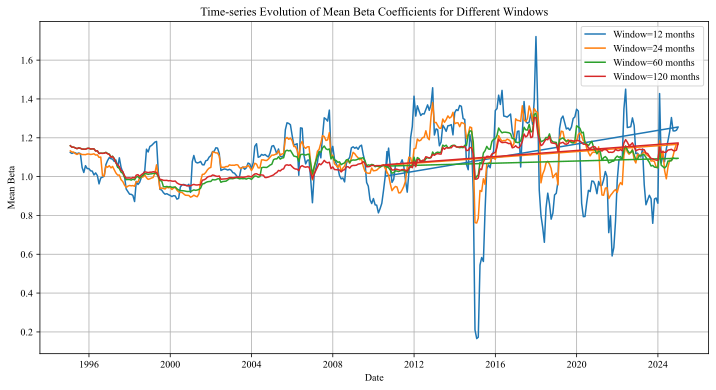

In [49]:
# 计算每个截面上的描述性统计量
cross_sectional_stats = []

# 获取所有月份，并只保留1995年以后的月份
all_months = results_df['month'][results_df['month'] >= '1995-01-01'].unique()

# 对每个月份进行统计
for month in all_months:
    month_data = results_df[results_df['month'] == month]
    
    # 计算每个窗口期的beta的描述性统计
    for window in [12, 24, 60, 120]:
        beta_col = f'beta_{window}'
        
        # 跳过没有足够数据的月份
        if month_data[beta_col].notna().sum() < 5:  # 至少需要5个有效观测值
            continue
            
        stats = {
            'month': month,
            'window': window,
            'mean': month_data[beta_col].mean(),
            'median': month_data[beta_col].median(),
            'std': month_data[beta_col].std(),
            'min': month_data[beta_col].min(),
            'max': month_data[beta_col].max(),
            'p25': month_data[beta_col].quantile(0.25),
            'p75': month_data[beta_col].quantile(0.75),
            'count': month_data[beta_col].notna().sum()
        }
        
        cross_sectional_stats.append(stats)

# 转换为DataFrame
cs_stats_df = pd.DataFrame(cross_sectional_stats)

# 在时间序列上计算平均值
time_series_avg = cs_stats_df.groupby('window').agg({
    'mean': 'mean',
    'median': 'mean',
    'std': 'mean',
    'min': 'mean',
    'max': 'mean',
    'p25': 'mean',
    'p75': 'mean',
    'count': 'mean'
}).reset_index()

# 显示时间序列平均结果
print("Time-series average descriptive statistics of Beta coefficients:")
display(time_series_avg)

# 绘制不同窗口期的beta均值随时间的变化
plt.figure(figsize=(12, 6))

for window in [12, 24, 60, 120]:
    window_data = cs_stats_df[cs_stats_df['window'] == window]
    if not window_data.empty:
        plt.plot(pd.to_datetime(window_data['month']), window_data['mean'], label=f'Window={window} months')

plt.title('Time-series Evolution of Mean Beta Coefficients for Different Windows')
plt.xlabel('Date')
plt.ylabel('Mean Beta')
plt.legend()
plt.grid(True)
plt.show();


## Betting Against Beta

使用日度数据估计 BAB beta

\begin{equation}
\hat{\beta}_i^{t s}=\hat{\rho} \frac{\hat{\sigma}_i}{\hat{\sigma}_m}
\end{equation}

In [12]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from pandas._libs.tslibs.offsets import MonthEnd

# 1. 计算log日收益率
Ret_day['log_ret'] = np.log(1 + Ret_day['Dretwd'])
Ret_day['log_ret_mkt'] = np.log(1 + Ret_day['MarketR'])

# 初始化结果DataFrame
results = []

# 获取所有股票代码
all_stocks = Ret_day['Stkcd'].unique()

# 处理每只股票
for stkcd in tqdm(all_stocks, desc="处理股票"):
    # 获取该股票的所有数据，并按日期排序
    stock_data = Ret_day[Ret_day['Stkcd'] == stkcd].sort_values('Day')
    
    # 获取该股票的所有月份
    stock_months = stock_data['month'].unique()
    
    # 对每个月进行处理
    for current_month in stock_months:
        # 初始化当月结果
        result = {
            'Stkcd': stkcd,
            'month': current_month
        }
        
        # 1. 计算过去12个月日收益率的标准差
        # 计算窗口的起始月份
        start_month_12 = current_month - pd.DateOffset(months=11)
        
        # 提取窗口内的数据
        window_data_12 = stock_data[(stock_data['month'] >= start_month_12) & 
                                  (stock_data['month'] <= current_month)]
        
        if len(window_data_12) > 0:
            # 计算log日收益率的标准差
            result['std_log_ret_12m'] = window_data_12['log_ret'].std()
            result['obs_log_ret_12m'] = len(window_data_12)
        else:
            result['std_log_ret_12m'] = np.nan
            result['obs_log_ret_12m'] = 0
            
        # 2. 计算过去60个月三天复合收益率与市场收益率的相关系数
        # 计算窗口的起始月份
        start_month_60 = current_month - pd.DateOffset(months=59)
        
        # 提取窗口内的数据
        window_data_60 = stock_data[(stock_data['month'] >= start_month_60) & 
                                  (stock_data['month'] <= current_month)]
        
        if len(window_data_60) > 60:  # 确保有足够的数据
            # 创建日期列表，并按顺序排列
            dates = sorted(window_data_60['Day'].unique())
            
            # 创建存储三天复合收益率的列表
            three_day_stock_returns = []
            three_day_market_returns = []
            
            # 计算每个三天窗口的复合收益率
            for i in range(0, len(dates) - 2, 3):
                # 提取三天数据
                three_days = window_data_60[window_data_60['Day'].isin(dates[i:i+3])]
                
                if len(three_days) == 3:  # 确保有完整的三天数据
                    # 计算股票的三天log复合收益率
                    stock_return = three_days['log_ret'].sum()
                    three_day_stock_returns.append(stock_return)
                    
                    # 计算市场的三天log复合收益率
                    market_return = three_days['log_ret_mkt'].sum()
                    three_day_market_returns.append(market_return)
            
            # 计算相关系数
            if len(three_day_stock_returns) > 5:  # 确保有足够的三天窗口
                corr = np.corrcoef(three_day_stock_returns, three_day_market_returns)[0, 1]
                result['corr_3day_60m'] = corr
                result['obs_3day_60m'] = len(window_data_60)
            else:
                result['corr_3day_60m'] = np.nan
                result['obs_3day_60m'] = len(window_data_60)
        else:
            result['corr_3day_60m'] = np.nan
            result['obs_3day_60m'] = 0
            
        # 将当月结果添加到总结果列表
        results.append(result)

# 转换为DataFrame
results_df = pd.DataFrame(results)

# 保存结果
results_df.to_csv('/Volumes/BetaAlpha/Asset-Pricing-Homework/volatility_and_correlation.csv', index=False)

# 显示结果
results_df

处理股票: 100%|██████████| 4827/4827 [8:52:38<00:00,  6.62s/it]  


,Stkcd,month,std_log_ret_12m,obs_log_ret_12m,corr_3day_60m,obs_3day_60m
0,000001,1991-04-30,0.046777,20,NaN,0
1,000001,1991-05-31,0.031504,44,NaN,0
2,000001,1991-06-30,0.025576,67,0.093389,67
3,000001,1991-07-31,0.023170,83,0.179612,83
4,000001,1991-08-31,0.067603,98,0.919450,98
...,...,...,...,...,...,...
738766,605599,2024-08-31,0.021969,242,0.302417,721
738767,605599,2024-09-30,0.022729,241,0.315940,740
738768,605599,2024-10-31,0.022476,242,0.356313,758
738769,605599,2024-11-30,0.022606,241,0.358240,779
